In [1]:
# create spark and sparkcontext objects
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.sql import functions as fn
import matplotlib.pylab as plt
import numpy as np
from pyspark.ml import feature, regression, Pipeline, classification, pipeline, evaluation
from pyspark.ml.tuning import ParamGridBuilder

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:


#airlines = spark.read.format("csv").option("header", "true").load("airlines.csv")
#airports = spark.read.format("csv").option("header", "true").load("airports.csv")
#flights = spark.read.format("csv").option("header", "true").load("flights.csv")
flights = spark.read.csv('flights.csv', header=True, inferSchema=True)
#spark.createDataFrame(flights)
#flight = pd.read_csv("flights.csv")
#flights = spark.createDataFrame(flights)

In [3]:
import re
#airlines_df = spark.createDataFrame(airlines)
#airports_df = spark.createDataFrame(airports)
#flights_df = spark.createDataFrame(flights)
relaced = flights.withColumn("ORIGIN_AIRPORT_NEW", fn.regexp_replace(fn.col("ORIGIN_AIRPORT"), "\\d", "NULL"))
flight = relaced.withColumn("DESTINATION_AIRPORT_NEW", fn.regexp_replace(fn.col("DESTINATION_AIRPORT"), "\\d", "NULL"))
#replaced = re.sub('\\d', 'NA', flights['ORIGIN_AIRPORT','DESTINATION_AIRPORT'])
#flight.show(10)
#Filtered_data = relaced.dropna()
flight.describe().toPandas()

,summary,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,ORIGIN_AIRPORT_NEW,DESTINATION_AIRPORT_NEW
0,count,5819079,5819079,5819079,5819079,5819079,5819079,5804358,5819079,5819079,...,5819079,5819079,89884,1063439,1063439,1063439,1063439,1063439,5819079,5819079
1,mean,2015.0,6.524085168804204,15.70459397440729,3.9269411877721545,None,2173.0927423394664,None,12666.699787109315,12666.853627883538,...,0.0026098631759424473,0.015446430612129514,None,13.480568231934319,0.07615387436420895,18.969546913363153,23.472837652183152,2.915289922600168,None,None
2,stddev,0.0,3.4051368280554697,8.783425069807226,1.9888450134329905,None,1757.0639987866211,None,1526.7134944584895,1526.6619201888464,...,0.051020116008060244,0.12332007544158718,None,28.003678900236313,2.1434595705026056,48.161641898325605,43.197018477241386,20.433335717631316,None,None
3,min,2015,1,1,1,AA,1,7819A,10135,10135,...,0,0,A,0,0,0,0,0,ABE,ABE
4,max,2015,12,31,7,WN,9855,N9EAMQ,YUM,YUM,...,1,1,D,1134,573,1971,1331,1211,YUM,YUM


In [4]:
# displaying and counting airlines dataset elements
#airlines.show()
#airlines.count()
#flight.show(10)

In [5]:
# displaying and counting airports dataset elements
#airports.show()
#airports.count()

In [6]:
# displaying and counting flights dataset elements
flight = flight.withColumn("AIRTIME_DELAY",fn.col('ELAPSED_TIME') - fn.col('SCHEDULED_TIME'))
#flights.count()

In [7]:
#len(flight.columns), flight.columns

In [8]:
flights_df = flight.drop('CANCELLATION_REASON',
                          'AIR_SYSTEM_DELAY',
                          'SECURITY_DELAY',
                          'AIRLINE_DELAY',
                          'LATE_AIRCRAFT_DELAY',
                          'WEATHER_DELAY',
                         'ORIGIN_AIRPORT',
                          'DESTINATION_AIRPORT')

In [9]:
flights_df.count()

5819079

In [10]:
flights.printSchema()

root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (null

In [11]:
flights_df.printSchema()


root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: integer (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: integer (nullable = true)
 |-- DISTANCE: integer (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIVAL_DELAY: integer (nullable = true)
 |-- DIVERTED: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)
 

In [12]:
flight_trial = flights

In [13]:
sumar = flight_trial.describe().filter(fn.col("summary") == "count")
plot_data = sumar.select(*((fn.lit(flight_trial.count())-fn.col(c)).alias(c) for c in flight_trial.columns)).toPandas()

In [14]:
#  for c in flight_trial.columns
#flight_trial.select(*((fn.count(c)).alias(c) for c in flight_trial.columns)).show()

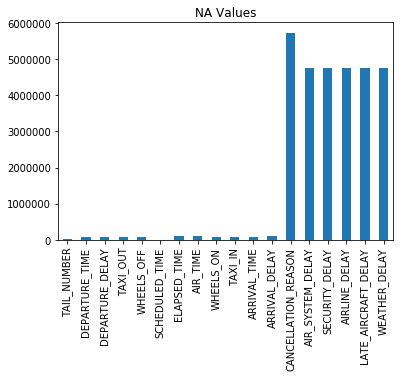

In [15]:

#plot_data.CANCELLED > 0 
#love = plot_data.filter(lambda x: [plot_data[i]>0 for i in plot_data.columns ])

df = pd.DataFrame()
newdf = pd.DataFrame([plot_data[c] > 0 for c in plot_data.columns])
pl_dat = pd.DataFrame(np.transpose(plot_data))
pl_dat['polarity'] = newdf[0]
na_values = pl_dat.loc[pl_dat['polarity'] == True]
na_values.plot.bar(legend = False, title = 'NA Values')
#[plot_data[i]>0 for i in plot_data.columns]
#large_values = pd.filter(lambda y: y > 10)

In [16]:
print("Number of entries before removing NAs:",flights_df.count())
print("NA Values:")
print(na_values)
print("Number of entries before removing NAs:",flights_df.dropna().count())


Number of entries before removing NAs: 5819079
NA Values:
                             0  polarity
TAIL_NUMBER            14721.0      True
DEPARTURE_TIME         86153.0      True
DEPARTURE_DELAY        86153.0      True
TAXI_OUT               89047.0      True
WHEELS_OFF             89047.0      True
SCHEDULED_TIME             6.0      True
ELAPSED_TIME          105071.0      True
AIR_TIME              105071.0      True
WHEELS_ON              92513.0      True
TAXI_IN                92513.0      True
ARRIVAL_TIME           92513.0      True
ARRIVAL_DELAY         105071.0      True
CANCELLATION_REASON  5729195.0      True
AIR_SYSTEM_DELAY     4755640.0      True
SECURITY_DELAY       4755640.0      True
AIRLINE_DELAY        4755640.0      True
LATE_AIRCRAFT_DELAY  4755640.0      True
WEATHER_DELAY        4755640.0      True
Number of entries before removing NAs: 5714008


In [10]:
#Filtered_data.select(*(fn.corr(fn.col('AIR_TIME'),fn.col(c)).alias(c) for c in Filtered_data.columns)).toPandas()
Filtered_data = flights_df.dropna()
#Filtered_data.describe().toPandas()
#Filtered_data.printSchema()
#Filtered_data.select('Depature_Delay').show()
#Values_consi = Filtered_data.select('AIRTIME_DELAY','MONTH_SI',\
#                                    'DAY_SI','DAY_OF_WEEK_SI',\
#                                    'AIRLINE_SI','DEPARTURE_TIME_SI','ARRIVAL_TIME_SI',\
#                                    'ORIGIN_AIRPORT_NEW_SI','DESTINATION_AIRPORT_NEW_SI') 

In [17]:
#Categorising the Departure Time and Arrival Time

In [11]:
Filtered_data=Filtered_data.withColumn("DEPARTURE_TIME", fn.when((fn.col('DEPARTURE_TIME') >= 600)
                                                    & (fn.col('DEPARTURE_TIME')<1200),fn.lit('Morning'))
                                 .otherwise(fn.when((fn.col('DEPARTURE_TIME') >= 1200)
                                                    & (fn.col('DEPARTURE_TIME') < 1600),fn.lit('Afternoon'))
                                 .otherwise(fn.when((fn.col('DEPARTURE_TIME') >= 1600)
                                                    & (fn.col('DEPARTURE_TIME') < 2100),fn.lit('Evening'))
                                 .otherwise(fn.when((fn.col('DEPARTURE_TIME') >= 2100)
                                                    & (fn.col('DEPARTURE_TIME') < 2400),fn.lit('Night'))
                                 .otherwise(fn.lit('Early_Morning'))))))

Filtered_data=Filtered_data.withColumn("ARRIVAL_TIME", fn.when((fn.col('ARRIVAL_TIME') >= 600)
                                                    & (fn.col('ARRIVAL_TIME')<1200),fn.lit('Morning'))
                                 .otherwise(fn.when((fn.col('ARRIVAL_TIME') >= 1200)
                                                    & (fn.col('ARRIVAL_TIME') < 1600),fn.lit('Afternoon'))
                                 .otherwise(fn.when((fn.col('ARRIVAL_TIME') >= 1600)
                                                    & (fn.col('ARRIVAL_TIME') < 2100),fn.lit('Evening'))
                                 .otherwise(fn.when((fn.col('ARRIVAL_TIME') >= 2100)
                                                    & (fn.col('ARRIVAL_TIME') <= 2400),fn.lit('Night'))           
                                 .otherwise(fn.lit('Early_Morning'))))))


In [12]:
Filtered_data.select('DEPARTURE_TIME','SCHEDULED_DEPARTURE','DEPARTURE_DELAY','ARRIVAL_TIME','SCHEDULED_ARRIVAL').show(10000)
Filtered_data.count()

+--------------+-------------------+---------------+-------------+-----------------+
|DEPARTURE_TIME|SCHEDULED_DEPARTURE|DEPARTURE_DELAY| ARRIVAL_TIME|SCHEDULED_ARRIVAL|
+--------------+-------------------+---------------+-------------+-----------------+
|         Night|                  5|            -11|Early_Morning|              430|
| Early_Morning|                 10|             -8|      Morning|              750|
| Early_Morning|                 20|             -2|      Morning|              806|
| Early_Morning|                 20|             -5|      Morning|              805|
| Early_Morning|                 25|             -1|Early_Morning|              320|
| Early_Morning|                 25|             -5|      Morning|              602|
| Early_Morning|                 25|             -6|Early_Morning|              526|
| Early_Morning|                 30|             14|      Morning|              803|
| Early_Morning|                 30|            -11|Early_Morning

5714008

In [13]:
#Filtered_data.select(*(fn.corr(fn.col('SCHEDULED_ARRIVAL'),fn.col(c)).alias(c) for c in Filtered_data.columns)).toPandas()
#Values_consi.printSchema()
#type(Filtered_data)
#type(Values_consi)
#categorical_data = ["MONTH","DAY", "DAY_OF_WEEK", "AIRLINE","DEPARTURE_TIME","ARRIVAL_TIME","ORIGIN_AIRPORT_NEW",\
#                    "DESTINATION_AIRPORT_NEW"]
#string_indexer = []
#one_hot_encoder = []
#for col_name in categorical_data:
#    indexer = feature.StringIndexer(inputCol=col_name, outputCol="{0}_SI".format(col_name)).fit(Filtered_data)
#    Filtered_data_new = indexer.transform(Filtered_data)
#    string_indexer.append(indexer)
#    
#    encoder = feature.OneHotEncoder(inputCol="{0}_SI".format(col_name), outputCol="{0}_EN".format(col_name), dropLast=False)
#    Filtered_data_new = encoder.transform(Filtered_data)
    
#    one_hot_encoder.append(encoder)

In [14]:
#Filtered_data.show(10)

In [15]:
Filtered_data.select(*(fn.corr(fn.col('AIRTIME_DELAY'),fn.col(c)).alias(c) for c in Filtered_data.columns)).toPandas()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,ORIGIN_AIRPORT_NEW,DESTINATION_AIRPORT_NEW,AIRTIME_DELAY
0,-0.00751,-0.049653,-0.008705,-0.019117,None,0.0816,None,-0.010679,None,0.016203,...,0.010279,0.319776,-0.008964,None,0.343282,None,None,None,None,1.0


In [16]:
#Values_consi.select(*(fn.corr(fn.col('AIRTIME_DELAY'),fn.col(c)).alias(c) for c in Values_consi.columns)).toPandas()

In [17]:
training_df, validation_df, testing_df = Filtered_data.randomSplit([0.6, 0.3, 0.1])
rmse = fn.sqrt(fn.avg((fn.col('AIRTIME_DELAY') - fn.col('prediction'))**2))

In [20]:
# With feature Month and String Indexer 
model_f1 = Pipeline(stages=[
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.VectorAssembler(inputCols=['encoded_M'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [27]:
model_f1.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.889710437836447|
+-------------------------------------------------+



In [28]:
# With feature Month and One Hot Encoding
model_f1_en = Pipeline(stages=[
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.VectorAssembler(inputCols=['en_M'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [29]:
model_f1_en.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.871540028517304|
+-------------------------------------------------+



In [30]:
# With feature DAY and String Indexer
model_f2 = Pipeline(stages=[
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.VectorAssembler(inputCols=['encoded_D'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_f2.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                12.89016499611307|
+-------------------------------------------------+



In [31]:
# With feature DAY and one hot encoder
model_f2_en = Pipeline(stages=[
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.VectorAssembler(inputCols=['en_D'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_f2_en.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.884169866849701|
+-------------------------------------------------+



In [32]:
# Seems Like One hot encoding results in a better result than just using indexing

In [33]:
# DAY of the week
model_f3_en = Pipeline(stages=[
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.VectorAssembler(inputCols=['en_DOW'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_f3_en.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.881298707379852|
+-------------------------------------------------+



In [34]:
# AIRLINE
model_f4_en = Pipeline(stages=[
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.VectorAssembler(inputCols=['en_AL'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_f4_en.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                12.66650782833711|
+-------------------------------------------------+



In [35]:
# Departure Time
model_f5_en = Pipeline(stages=[
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.VectorAssembler(inputCols=['en_DT'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_f5_en.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.888080535505507|
+-------------------------------------------------+



In [36]:
# Arrival Time
model_f6_en = Pipeline(stages=[
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.VectorAssembler(inputCols=['en_AT'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_f6_en.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.888786698550662|
+-------------------------------------------------+



In [37]:
# Origin Airport New
model_f7_en = Pipeline(stages=[
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.VectorAssembler(inputCols=['en_OA'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_f7_en.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.787073753851367|
+-------------------------------------------------+



In [38]:
# Destination Airport New
model_f8_en = Pipeline(stages=[
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['en_DA'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_f8_en.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.812591468901637|
+-------------------------------------------------+



In [21]:
# Combination of all Categorical features
model_cat_comb = Pipeline(stages=[
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='feature'),
  regression.LinearRegression(featuresCol='feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [40]:
model_cat_comb.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.532697961747143|
+-------------------------------------------------+



In [41]:
model2 = Pipeline(stages=[
  feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
  feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
  feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
  feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
  feature.VectorAssembler(inputCols=['en_M', 'en_OA'], outputCol='final_features'),
  regression.LinearRegression(featuresCol='final_features', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [42]:
model2.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               12.770894644998577|
+-------------------------------------------------+



In [43]:
model3 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['TAXI_OUT'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [44]:
model3.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                10.97160168176635|
+-------------------------------------------------+



In [45]:
model4 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [46]:
model4.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               10.712160350142472|
+-------------------------------------------------+



In [47]:
model5 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [48]:
model5.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                 9.80294923518742|
+-------------------------------------------------+



In [49]:
model6 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
  regression.LinearRegression(featuresCol='features', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [50]:
model6.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                9.800975173047783|
+-------------------------------------------------+



In [52]:
model7 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
  feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
  feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
  feature.VectorAssembler(inputCols=['features','en_M'], outputCol='final_features'),
  regression.LinearRegression(featuresCol='final_features', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [53]:
model7.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                9.784353616283894|
+-------------------------------------------------+



In [54]:
# I feel this is the the model to use
model8 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
  feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
  feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
  feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
  feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
  feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
  feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
  feature.VectorAssembler(inputCols=['features', 'en_M', 'en_DOW','en_OA'], outputCol='final_features'),
  regression.LinearRegression(featuresCol='final_features', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [55]:
model8.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                9.163138982221279|
+-------------------------------------------------+



In [56]:
model9 = Pipeline(stages=[
  feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
  feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
  feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
  feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
  feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
  feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
  feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
  feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
  feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
  feature.VectorAssembler(inputCols=['features', 'en_M', 'en_DOW', 'en_AL','en_OA'], outputCol='final_features'),
  regression.LinearRegression(featuresCol='final_features', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [57]:
model9.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                8.899325564935374|
+-------------------------------------------------+



In [22]:
# Combination of best output from numerical features and categorical features
model_cat_num_comb = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.LinearRegression(featuresCol='final_feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)

In [59]:
model_cat_num_comb.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                8.709683945935323|
+-------------------------------------------------+



In [60]:
model_cat_num_comb.transform(testing_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                8.710018414614652|
+-------------------------------------------------+



In [61]:
# Regularization

In [62]:
model_cat_num_comb_reg1 = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.LinearRegression(featuresCol='final_feature', labelCol='AIRTIME_DELAY', regParam=0., elasticNetParam=0.4)  
]).fit(training_df)
model_cat_num_comb_reg1.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                8.709683945935323|
+-------------------------------------------------+



In [63]:
model_cat_num_comb_reg2 = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.LinearRegression(featuresCol='final_feature', labelCol='AIRTIME_DELAY', regParam=0., elasticNetParam=0.8)  
]).fit(training_df)
model_cat_num_comb_reg2.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                8.709683945935323|
+-------------------------------------------------+



In [64]:
model_cat_num_comb_reg3 = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.LinearRegression(featuresCol='final_feature', labelCol='AIRTIME_DELAY', regParam=0.01, elasticNetParam=0.4)  
]).fit(training_df)
model_cat_num_comb_reg3.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                 8.71065613220068|
+-------------------------------------------------+



In [65]:
model_cat_num_comb_reg4 = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.LinearRegression(featuresCol='final_feature', labelCol='AIRTIME_DELAY', regParam=0.01, elasticNetParam=0.8)  
]).fit(training_df)
model_cat_num_comb_reg4.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                8.713189942764199|
+-------------------------------------------------+



In [66]:
model_cat_num_comb_reg5 = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.LinearRegression(featuresCol='final_feature', labelCol='AIRTIME_DELAY', regParam=0.02, elasticNetParam=0.4)  
]).fit(training_df)
model_cat_num_comb_reg5.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                8.713322540708184|
+-------------------------------------------------+



In [67]:
#all_models = []
#for j in range(len(grid)):
#    print("Fitting model {}".format(j+1))
#    model = el_re_estimator.fit(training_df, grid[j])
#    all_models.append(model)

In [68]:
#error = [m.transform(validation_df).select(rmse).show() for m in all_models]

In [69]:
model_cat_num_comb_reg6 = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.LinearRegression(featuresCol='final_feature', labelCol='AIRTIME_DELAY', regParam=0.02, elasticNetParam=0.8)  
]).fit(training_df)
model_cat_num_comb_reg6.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                8.722213849892777|
+-------------------------------------------------+



In [70]:
model_DT = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.DecisionTreeRegressor(featuresCol='final_feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_DT.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               10.470143494576476|
+-------------------------------------------------+



In [ ]:
model_DT.transform(testing_df).select(rmse).show()

In [71]:
model_RF = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.RandomForestRegressor(featuresCol='final_feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_RF.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                               10.506743281840626|
+-------------------------------------------------+



In [ ]:
model_RF.transform(testing_df).select(rmse).show()

In [72]:
model_GB = Pipeline(stages=[
      feature.VectorAssembler(inputCols=['TAXI_OUT','DISTANCE','TAXI_IN','DEPARTURE_DELAY'], outputCol='features'),
      feature.StringIndexer(inputCol='MONTH', outputCol='encoded_M'),
      feature.OneHotEncoder(inputCol='encoded_M', outputCol='en_M', dropLast=False),
      feature.StringIndexer(inputCol='DAY', outputCol='encoded_D'),
      feature.OneHotEncoder(inputCol='encoded_D', outputCol='en_D', dropLast=False),
      feature.StringIndexer(inputCol='DAY_OF_WEEK', outputCol='encoded_DOW'),
      feature.OneHotEncoder(inputCol='encoded_DOW', outputCol='en_DOW', dropLast=False),
      feature.StringIndexer(inputCol='AIRLINE', outputCol='encoded_AL'),
      feature.OneHotEncoder(inputCol='encoded_AL', outputCol='en_AL', dropLast=False),
      feature.StringIndexer(inputCol='DEPARTURE_TIME', outputCol='encoded_DT'),
      feature.OneHotEncoder(inputCol='encoded_DT', outputCol='en_DT', dropLast=False),
      feature.StringIndexer(inputCol='ARRIVAL_TIME', outputCol='encoded_AT'),
      feature.OneHotEncoder(inputCol='encoded_AT', outputCol='en_AT', dropLast=False),
      feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA'),
      feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA', dropLast=False),
      feature.StringIndexer(inputCol='DESTINATION_AIRPORT_NEW', outputCol='encoded_DA'),
      feature.OneHotEncoder(inputCol='encoded_DA', outputCol='en_DA', dropLast=False),
      feature.VectorAssembler(inputCols=['features','en_M','en_D','en_DOW','en_AL','en_DT','en_AT','en_OA','en_DA'], outputCol='final_feature'),
  regression.GBTRegressor(featuresCol='final_feature', labelCol='AIRTIME_DELAY')  
]).fit(training_df)
model_GB.transform(validation_df).select(rmse).show()

+-------------------------------------------------+
|SQRT(avg(POWER((AIRTIME_DELAY - prediction), 2)))|
+-------------------------------------------------+
|                                 9.65404410154843|
+-------------------------------------------------+



In [3]:
from pyspark.sql.functions import  col,struct

In [18]:
df = sc.parallelize([["simple_lr",8.7096],
                      ['decision_tree', 10.470],
                      ['random_forest',10.5067],
                      ['gradient_boosting',9.6540]
                    ]).\
    toDF(["model","error"])
df=df.toPandas()
df

,model,error
0,simple_lr,8.7096
1,decision_tree,10.4700
2,random_forest,10.5067
3,gradient_boosting,9.6540


[Text(0,0,'simple_lr'),
 Text(0,0,'decision_tree'),
 Text(0,0,'random_forest'),
 Text(0,0,'gradient_boosting')]

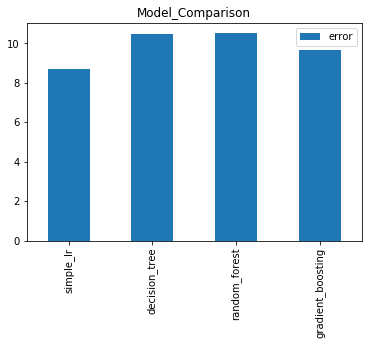

In [19]:
ax= df.plot.bar(title = 'Model_Comparison')
ax.set_xticks(df.index)
ax.set_xticklabels(df.model, rotation=90)

[Text(0,0,'simple_lr'),
 Text(0,0,'decision_tree'),
 Text(0,0,'random_forest'),
 Text(0,0,'gradient_boosting')]

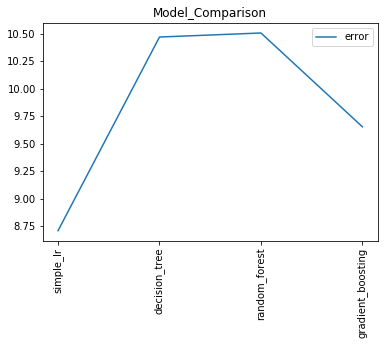

In [33]:
ax= df.plot.line(title = 'Model_Comparison')
ax.set_xticks(df.index)
ax.set_xticklabels(df.model, rotation=90)

In [20]:
df_lr = sc.parallelize([["lr_0_0.4",8.7096],
                      ['lr_0_0.8', 8.7096],
                      ['lr_0.1_0.4',8.7106],
                      ['lr_0.1_0.8',8.7131],
                     ['lr_0.02_0.4',8.7133],
                     ['lr_0.02_0.8',8.7222],
                    ]).\
    toDF(["lr_model","error"])
df_lr=df_lr.toPandas()
df_lr

,lr_model,error
0,lr_0_0.4,8.7096
1,lr_0_0.8,8.7096
2,lr_0.1_0.4,8.7106
3,lr_0.1_0.8,8.7131
4,lr_0.02_0.4,8.7133
5,lr_0.02_0.8,8.7222


[Text(0,0,'lr_0_0.4'),
 Text(0,0,'lr_0_0.8'),
 Text(0,0,'lr_0.1_0.4'),
 Text(0,0,'lr_0.1_0.8'),
 Text(0,0,'lr_0.02_0.4'),
 Text(0,0,'lr_0.02_0.8')]

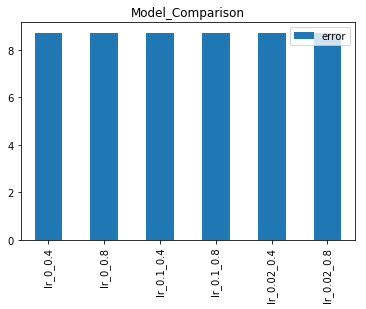

In [34]:
ax_lr= df_lr.plot.bar(title = 'Model_Comparison')#,yticks = range(0,5,1))

#ax_lr.set_xticks(df_lr.index)
ax_lr.set_xticklabels(df_lr.lr_model, rotation=90)

In [ ]:
plt.plot(x=)

In [ ]:
model_GB.transform(validation_df).select(rmse).show()

In [73]:
len(model_cat_num_comb.stages[-1].coefficients)

724

In [74]:
coff =model_cat_num_comb.stages[-1].coefficients
coff

DenseVector([0.9507, -0.0035, 0.9074, -0.0047, -0.1613, -0.3348, 0.2246, 0.4241, 0.4915, -0.1708, 0.9231, -0.9042, -0.7848, -0.4033, 0.404, 0.2979, -0.2737, 0.0211, -0.1207, -0.0135, 0.3107, -0.0616, 0.1303, 0.0743, 0.1028, -0.0941, -0.2471, 0.5317, -0.0909, -0.0482, 0.154, 0.3347, 0.2124, -0.2783, 0.1343, -0.2123, -0.0224, -0.1016, 0.1062, 0.0933, 0.1471, 0.0973, 0.059, -0.1286, -0.4671, -0.2286, -0.2706, 0.2324, 0.0626, 0.0215, -0.0007, 0.0731, -0.2315, -0.2007, 1.6139, -1.8868, -1.1478, -1.1161, 0.3699, -2.8975, -1.5655, 2.679, 0.1591, 2.01, 4.5347, 3.764, 6.4845, 5.3868, 0.0924, -0.5046, 0.3007, -0.041, 0.6993, 0.0384, -0.4033, 0.0645, 0.3148, 0.6509, -0.1708, -2.5546, -3.3798, -0.4533, 0.6717, 0.9603, 1.978, -0.3732, -0.8493, 0.9646, -0.5833, 1.7394, 0.8672, -2.5771, -4.0272, -0.7106, -6.9289, 0.5284, -13.0346, -12.5192, -0.8463, -0.0176, -1.9642, -2.6627, 1.6942, -1.0284, -5.5296, 2.6486, 3.5482, 4.2739, 4.9235, 3.1198, 1.8583, 0.4955, 5.7726, 3.0335, 3.349, 4.0925, 5.4724, 6.026

In [75]:
trial = Filtered_data.select('MONTH').toPandas()

In [76]:
trial['MONTH'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

In [77]:
month = Filtered_data.select('MONTH').toPandas()['MONTH'].unique()
month_coefficients= coff[4:16]
month_performance = pd.DataFrame(
    {'month': month,
     'coefficients': month_coefficients,
    })
month_performance

,month,coefficients
0,1,-0.161343
1,2,-0.334809
2,3,0.224558
3,4,0.424093
4,5,0.491515
5,6,-0.170806
6,7,0.923134
7,8,-0.904163
8,9,-0.784785
9,10,-0.403346


In [78]:
day = Filtered_data.select('DAY').toPandas()['DAY'].unique()
day_coefficients= coff[16:47]
day_performance = pd.DataFrame(
    {'day': day,
     'coefficients': day_coefficients,
    })
day_performance

,day,coefficients
0,1,-0.273685
1,2,0.021067
2,3,-0.120662
3,4,-0.013524
4,5,0.310720
5,6,-0.061648
6,7,0.130267
7,8,0.074284
8,9,0.102847
9,10,-0.094075


In [79]:
day_o_w = Filtered_data.select('DAY_OF_WEEK').toPandas()['DAY_OF_WEEK'].unique()
day_o_w_coefficients= coff[47:54]
day_o_w_performance = pd.DataFrame(
    {'day_o_w': day_o_w,
     'coefficients': day_o_w_coefficients,
    })
day_o_w_performance

,day_o_w,coefficients
0,4,0.232384
1,5,0.062621
2,6,0.021451
3,7,-0.000687
4,1,0.073082
5,2,-0.231515
6,3,-0.200723


In [80]:
airline = Filtered_data.select('AIRLINE').toPandas()['AIRLINE'].unique()
airline_coefficients= coff[54:68]
airline_performance = pd.DataFrame(
    {'airline': airline,
     'coefficients': airline_coefficients,
    })
airline_performance

,airline,coefficients
0,AS,1.613936
1,AA,-1.886804
2,US,-1.147834
3,DL,-1.116108
4,NK,0.369858
5,UA,-2.897489
6,HA,-1.565517
7,B6,2.678992
8,OO,0.159054
9,EV,2.009964


In [81]:
DT = Filtered_data.select('DEPARTURE_TIME').toPandas()['DEPARTURE_TIME'].unique()
DT_coefficients= coff[68:73]
DT_performance = pd.DataFrame(
    {'airline': DT,
     'coefficients': DT_coefficients,
    })
DT_performance

,airline,coefficients
0,Night,0.092380
1,Early_Morning,-0.504638
2,Morning,0.300722
3,Afternoon,-0.040978
4,Evening,0.699330


In [82]:
AT = Filtered_data.select('ARRIVAL_TIME').toPandas()['ARRIVAL_TIME'].unique()
AT_coefficients= coff[73:78]
AT_performance = pd.DataFrame(
    {'airline': AT,
     'coefficients': AT_coefficients,
    })
AT_performance

,airline,coefficients
0,Early_Morning,0.038378
1,Morning,-0.403342
2,Afternoon,0.064470
3,Evening,0.314833
4,Night,0.650918


In [83]:
#Si = feature.StringIndexer(inputCol='ORIGIN_AIRPORT_NEW', outputCol='encoded_OA').fit(Filtered_data)
#df = Si.transform(Filtered_data)
#ohe = feature.OneHotEncoder(inputCol='encoded_OA', outputCol='en_OA')
#df = ohe.transform(df)

In [84]:
OA = Filtered_data.select('ORIGIN_AIRPORT_NEW').toPandas()['ORIGIN_AIRPORT_NEW'].unique()
OA_coefficients= coff[78:401]
OA_performance = pd.DataFrame(
    {'Origin_Airport': OA,
     'coefficients': OA_coefficients,
    })
OA_performance

,Origin_Airport,coefficients
0,ANC,-0.170806
1,LAX,-2.554609
2,SFO,-3.379794
3,SEA,-0.453273
4,LAS,0.671653
5,DEN,0.960280
6,SLC,1.978019
7,PDX,-0.373205
8,FAI,-0.849267
9,MSP,0.964627


In [85]:
DA = Filtered_data.select('DESTINATION_AIRPORT_NEW').toPandas()['DESTINATION_AIRPORT_NEW'].unique()
DA_coefficients= coff[401:724]
DA_performance = pd.DataFrame(
    {'airline': DA,
     'coefficients': DA_coefficients,
    })
DA_performance

,airline,coefficients
0,SEA,-0.170806
1,PBI,-3.331279
2,CLT,-4.040644
3,MIA,-2.776255
4,ANC,-1.359963
5,MSP,-3.459629
6,DFW,-1.667642
7,ATL,0.365066
8,IAH,-0.036472
9,PDX,-0.715539


In [23]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [27]:
modelEvaluator=RegressionEvaluator()
pipeline = Pipeline(stages=[model_cat_num_comb.stages[-1]])
paramGrid = ParamGridBuilder().addGrid(model_cat_num_comb.stages[-1].regParam, [0.1, 0.01]).addGrid(model_cat_num_comb.stages[-1].elasticNetParam, [0, 1]).build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=3)

In [29]:
cvModel = crossval.fit(training_df)

Py4JJavaError: An error occurred while calling o1385.w.
: java.lang.ClassCastException
